# Going beyond simple CBMs

In [1]:
import patches
import torch
import torch.utils as utils
import lettertask
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import plotnine as gg
import lazytools_sflippl as lazytools
import time
import pandas as pd

In [2]:
cbm = lettertask.data.CompositionalBinaryModel(
    width=[50, 10, 20, 40, 100, 40],
    change_probability=[0.05, 0.5, 0.2, 0.5, 0.1, 0.2],
    samples=100000,
    seed=None
)

In [3]:
cts = patches.data.Contrastive1DTimeSeries(cbm.to_array())

In [4]:
cdl = utils.data.DataLoader(cts, batch_size=8, drop_last=True)

In [5]:
ce = patches.networks.LinearScaffold(2, data=cts, bias=False)

In [6]:
criterion = patches.losses.ContrastiveLoss(loss=patches.losses.BilinearLoss())

In [7]:
ideal_1 = np.array([1]*50+[0]*(10+20+40+100+40))/np.sqrt(50)

In [8]:
ideal_2 = np.array([0]*(50+10+20+40)+[1]*100+[0]*40)/np.sqrt(100)

In [9]:
optimizer = optim.Adam(ce.parameters(), lr=1e-2)
angle_1 = []
angle_2 = []
loss_traj = []
running_loss = 0
n_epochs = 1
with tqdm(total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        running_loss = 0
        for i, data in enumerate(cdl):
            if i<len(cdl):
                if i % 10 == 0:
                    est = list(ce.parameters())[0].detach().numpy()
                    angle_1.append(np.matmul(ideal_1, est[0,:].T)/np.sqrt(np.matmul(est[0,:], est[0,:].T)) +
                                   np.matmul(ideal_1, est[1,:].T)/np.sqrt(np.matmul(est[1,:], est[1,:].T)))
                    angle_2.append(np.matmul(ideal_2, est[0,:].T)/np.sqrt(np.matmul(est[0,:], est[0,:].T)) +
                                   np.matmul(ideal_2, est[1,:].T)/np.sqrt(np.matmul(est[1,:], est[1,:].T)))
                optimizer.zero_grad()
                code = ce(data)
                loss = criterion(code)
                loss.backward()
                optimizer.step()
                running_loss += loss
                if i % 500 == 499:
                    loss_traj.append(running_loss.detach().numpy()/500)
                    running_loss = 0
                pbar.update(1/len(cdl))

1.0000000000002733it [00:37, 37.30s/it]                       


In [39]:
est.shape

(2, 260)

In [10]:
loss_df = lazytools.array_to_dataframe(np.array(loss_traj))\
                   .rename(columns={'dim0': 'steps', 'array': 'loss'})

In [11]:
np.matmul(est, est.T)

array([[178.66173  ,   7.4092574],
       [  7.4092574, 242.62631  ]], dtype=float32)

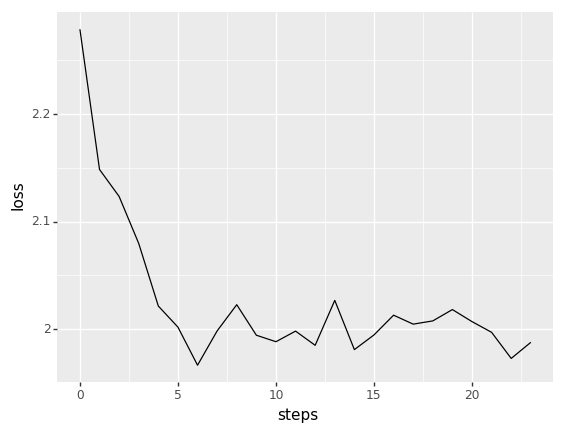

<ggplot: (-9223363261129284920)>

In [14]:
(gg.ggplot(loss_df, gg.aes(x='steps', y='loss')) +
    gg.geom_line())

In [15]:
angle_1_df = lazytools.array_to_dataframe(np.array(angle_1))\
                      .rename(columns={'dim0': 'steps', 'array': 'angle'})
angle_1_df['latent_dim'] = np.array('1')

In [16]:
angle_2_df = lazytools.array_to_dataframe(np.array(angle_2))\
                      .rename(columns={'dim0': 'steps', 'array': 'angle'})
angle_2_df['latent_dim'] = np.array('2')

In [17]:
angle_df = pd.concat([angle_1_df, angle_2_df])

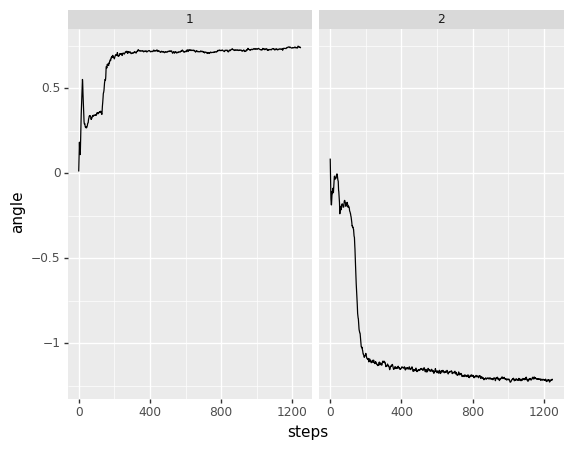

<ggplot: (-9223363261129314984)>

In [18]:
(gg.ggplot(angle_df, gg.aes(x='steps', y='angle')) +
    gg.geom_line() + 
    gg.facet_wrap('latent_dim'))